##Importación del Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
from google.colab import files
files.upload() #this will prompt you to update the json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Saving kaggle.json to kaggle.json
kaggle.json


In [4]:
#Search for datasets and competitions by name
!kaggle datasets list -s 'in-vehicle coupon recommendation'

ref                                            title                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------  ---------------------------------  ----  -------------------  -------------  ---------  ---------------  
mathurinache/invehicle-coupon-recommendation    in-vehicle coupon recommendation  94KB  2021-03-09 19:14:37            538         19  1.0              
adityavats/invehicle-coupon-recommendation     In-vehicle Coupon Recommendation   94KB  2021-11-15 20:34:57             12          2  0.64705884       
drserkankaya/in-vehicle-coupon-recommendation  In vehicle coupon recommendation   94KB  2022-04-04 12:22:01              0          0  0.1764706        


In [5]:
#Download required dataset / competition files to a folder of your choice
!kaggle datasets download -d mathurinache/invehicle-coupon-recommendation -p /content/drive/My\ Drive/MAESTRIA_PUCP/MACHINE_LEARNING/PROYECTO_FINAL/dataset

invehicle-coupon-recommendation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
#Descomprimimos el dataset descargado
import os
os.chdir('/content/drive/My Drive/MAESTRIA_PUCP/MACHINE_LEARNING/PROYECTO_FINAL/dataset')  #change dir
!unzip -q invehicle-coupon-recommendation.zip

replace in-vehicle-coupon-recommendation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


##Importación de Librerías

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

pd.set_option("display.max_columns", 50)

%matplotlib inline

##Revisión del Dataset

In [8]:
os.chdir('/content/')  #change dir

In [9]:
!ls

drive  kaggle.json  sample_data


In [10]:
rutaDrive = 'drive/My Drive/MAESTRIA_PUCP/MACHINE_LEARNING/PROYECTO_FINAL/dataset/'

In [11]:
#Lectura del dataset
file_name = "in-vehicle-coupon-recommendation.csv"

#El método "read_csv" nos permite leer un excel
dataset = pd.read_csv(rutaDrive+file_name)

In [12]:
#Tamaño del dataset (registros, variables). En la nomenclatura de pandas es (axis 0, axis 1)
dataset.shape

(12684, 26)

In [13]:
#Vemos los primeros registros del dataset
dataset.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


##Pre-procesamiento del Dataset


In [14]:
def preprocess_dataset(dataset, save_metadata=True):
  preprocessed_dataset = dataset.copy()
  
  #Eliminamos la variable "toCoupon_GEQ5min"
  preprocessed_dataset.drop("toCoupon_GEQ5min", axis=1, inplace=True)

  #Eliminamos la variable "direction_same"
  preprocessed_dataset.drop("direction_same", axis=1, inplace=True)

  #Determinamos aquellas variables que tengan un porcentaje de registros nulos por cada variable mayor al valor de 0.7
  threshold = 0.7
  null_percentages = preprocessed_dataset.isna().sum() / len(preprocessed_dataset)
  criteria = null_percentages > threshold
  columns_to_filter = null_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Determinamos que variables son del tipo númerico y cuales son categóricas
  numeric_columns = list()
  categorical_columns = list()
  dictionary_of_columns_with_index_to_categorical = dict()
  dictionary_of_columns_with_categorical_to_index = dict()

  for column in preprocessed_dataset:
      #Determinamos si la variable es numérica o no
      if pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
        numeric_columns.append(column)
      else:
        #Modificamos el tipo de dato de la variable mediante "astype"
        preprocessed_dataset[column] = preprocessed_dataset[column].astype("category")

        #Verificamos si el tipo de dato de la variable fue transformado a categórico correctamente
        if not pd.api.types.is_categorical_dtype(preprocessed_dataset[column]):
          raise Exception("La columna {} no se transformó correctamente a categórica".format(column))

        dictionary_of_columns_with_index_to_categorical[column] = dict()
        dictionary_of_columns_with_categorical_to_index[column] = dict()
        
        #Indexamos los valores (categorías), sin tomar en consideración los nulos, de la variable y guardamos esa información en los diccionarios
        for index, category in enumerate(preprocessed_dataset[column].cat.categories):
          dictionary_of_columns_with_index_to_categorical[column][index] = category
          dictionary_of_columns_with_categorical_to_index[column][category] = index
        
        categorical_columns.append(column)
    
  #Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
  median_of_numeric_columns = preprocessed_dataset[numeric_columns].median()

  preprocessed_dataset[numeric_columns] = preprocessed_dataset[numeric_columns].fillna(median_of_numeric_columns)

  #Transformamos a números los valores (categorías) de las variables categóricas sin considerar los nulos
  preprocessed_dataset.replace(dictionary_of_columns_with_categorical_to_index, inplace=True)

  #Generamos una nueva lista de variables categóricas y las variables eliminadas por tener un porcentaje alto de registros nulos
  categorical_columns_filtered = categorical_columns[:]
  
  if len(categorical_columns_filtered) > 0:
    #Reemplazamos los nulos con la mediana para todas las variables y las variables eliminadas por tener un porcentaje alto de registros nulos
    median_of_categorical_columns = preprocessed_dataset[categorical_columns_filtered].median()

    preprocessed_dataset[categorical_columns_filtered] = preprocessed_dataset[categorical_columns_filtered].fillna(median_of_categorical_columns)
  
  if save_metadata:
    #Guardamos información que consideremos imporante. El formato pickle nos permite guardar objetos de python
    with open("numeric_columns.pkl", "wb") as f:
      pickle.dump(numeric_columns, f)
    
    with open("categorical_columns.pkl", "wb") as f:
      pickle.dump(categorical_columns, f)
    
    with open("dictionary_of_columns_with_index_to_categorical.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_index_to_categorical, f)
    
    with open("dictionary_of_columns_with_categorical_to_index.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_categorical_to_index, f)
      
  return preprocessed_dataset

In [15]:
#Preprocesamos los datos
preprocessed_dataset = preprocess_dataset(dataset)

In [16]:
#Guardamos nuestro dataset pre-procesado en formato pickle
preprocessed_dataset.to_pickle("preprocessed_dataset_in_vehicle_train.pkl")

In [17]:
preprocessed_dataset.shape

(12610, 23)

In [18]:
preprocessed_dataset.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_opp,Y
0,1,0,2,55,2,4,0,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,0,0,1,1
1,1,1,2,80,0,2,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,0,0,1,0
2,1,1,2,80,0,1,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,1
3,1,1,2,80,2,2,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,0
4,1,1,2,80,2,2,0,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,0


In [19]:
#Cargamos los datos previamente guardados
with open("numeric_columns.pkl", "rb") as f:
    numeric_columns = pickle.load(f)

with open("categorical_columns.pkl", "rb") as f:
  categorical_columns = pickle.load(f)

with open("dictionary_of_columns_with_index_to_categorical.pkl", "rb") as f:
  dictionary_of_columns_with_index_to_categorical = pickle.load(f)

with open("dictionary_of_columns_with_categorical_to_index.pkl", "rb") as f:
  dictionary_of_columns_with_categorical_to_index = pickle.load(f)

preprocessed_dataset = pd.read_pickle("preprocessed_dataset_in_vehicle_train.pkl")

In [20]:
numeric_columns

['temperature',
 'has_children',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_opp',
 'Y']

In [21]:
categorical_columns

['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'occupation',
 'income',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50']

In [22]:
dictionary_of_columns_with_index_to_categorical["passanger"]

{0: 'Alone', 1: 'Friend(s)', 2: 'Kid(s)', 3: 'Partner'}

## Visualizamos la data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


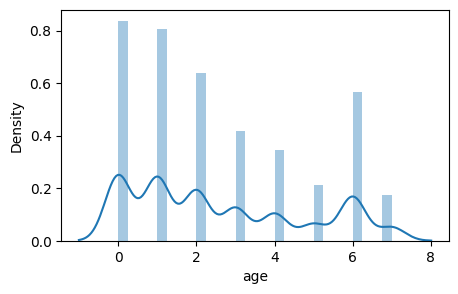

In [23]:
width = 5
height = 3

plt.style.use("default")

plt.figure(figsize=(width, height))

sns.distplot(preprocessed_dataset['age'], )

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

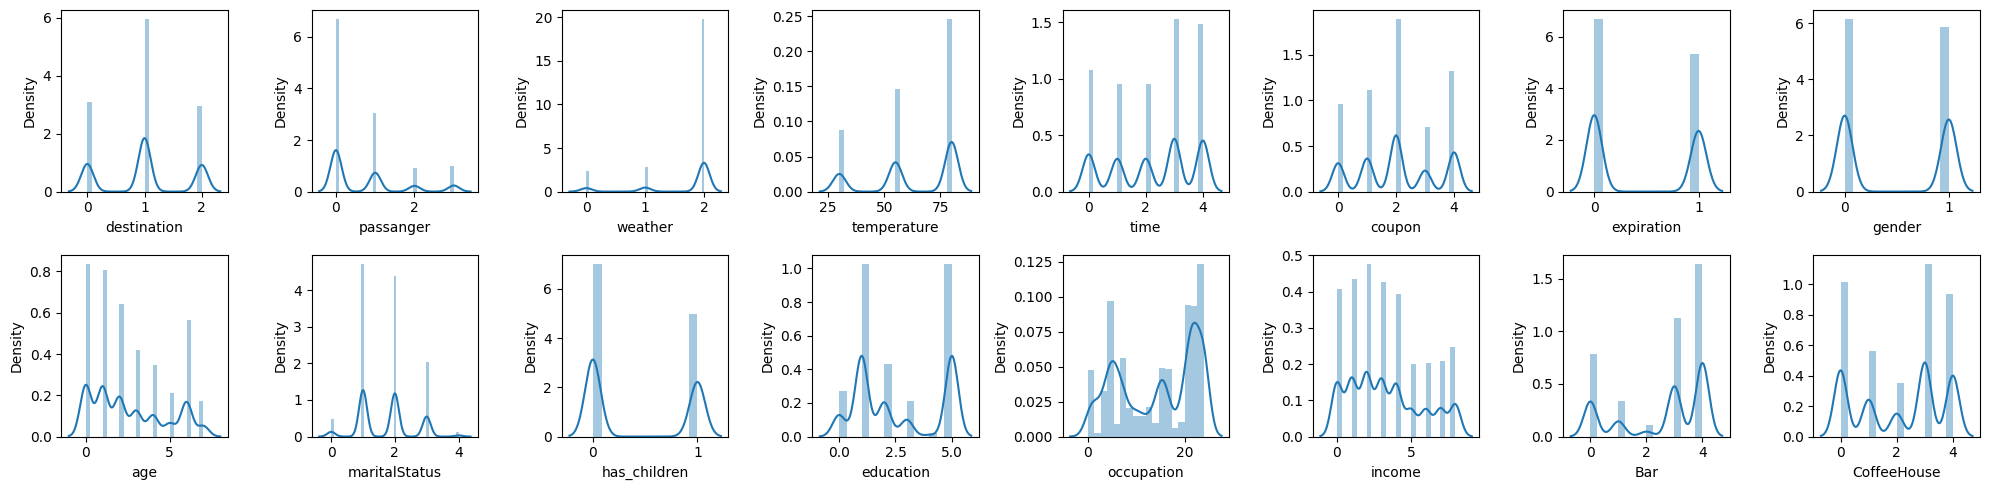

In [24]:
width = 20
height = 5

plt.style.use("default")

figure, axes = plt.subplots(nrows=2, ncols=8, figsize=(width, height))

for column, axe in zip(preprocessed_dataset, axes.flatten()):
    sns.distplot(preprocessed_dataset[column], ax=axe)
    
plt.tight_layout()

## Dividimos la data

In [25]:
#Separamos la data, en variables independientes (x) y dependientes (y), para poder entrenar un árbol de clasificación
x = preprocessed_dataset.drop("Y", axis=1)

y = preprocessed_dataset["Y"]

In [26]:
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [27]:
print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

Train shape: (10088, 22)
Test shape: (2522, 22)


##Entrenamiento del modelo

##**XGBoost**

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn import metrics

## Tuneo de Hiperparámetros

Búsqueda de los mejores parámetros para el entrenamiento de nuestro modelo XGBoost. 

Nos basamos de la referencia de [Jayanta Kumar](https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73).


In [30]:
clf_xgb = XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
#kfold_5 = cross_validation.KFold(n = len(X), shuffle = True, n_folds = numFolds)

rs_clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = 3,  
                         n_iter = 5, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

rs_clf.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, error_score=0, estimator=XGBClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f781b56ac10>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f781b56a150>,
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f781b56a050>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f781b56a310>},
                   scoring='roc_auc', verbose=3)

### Se realiza la evaluación del modelo con los mejores parámetros encontrados con el modelo **RandomizedSearchCV**, encontrándose un Score del 84.70 %

In [31]:
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: 0.8191090786616017
Best params: 
colsample_bytree: 0.8498731892350998
learning_rate: 0.05877212386872883
max_depth: 6
min_child_weight: 3
n_estimators: 257
subsample: 0.7668421174743933


In [36]:
y_pred = rs_clf.predict(x_test)
print("Accuracy", accuracy_score(y_test, y_pred)*100)

Accuracy 75.61459159397303


In [38]:
rs_clf.score(x_test,y_test)

0.8264810042908723

## Curva ROC

En base al modelo evaluado se obtiene un AUC= 0.83

AUC = 0.8264810042908723


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


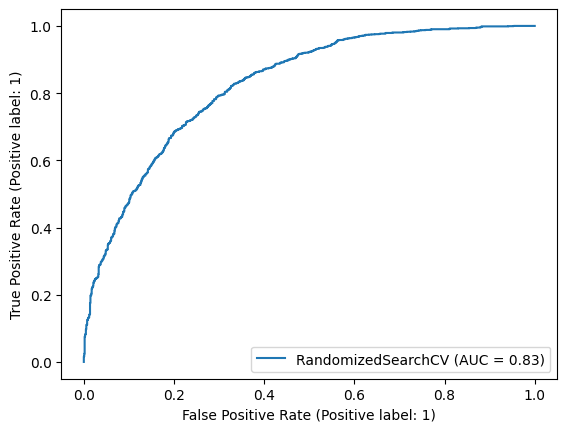

In [33]:
y_pred_val_Xgb = rs_clf.predict_proba(x_test)[:,1]
auc_roc_Xgb = metrics.roc_auc_score(y_test, y_pred_val_Xgb)
print('AUC =', auc_roc_Xgb)

metrics.plot_roc_curve(rs_clf, x_test, y_test)
plt.show()

## Feature Importance

Se determina que la característica **coupon** es la más importante para determinar si un conductor aceptará o no un cupón.

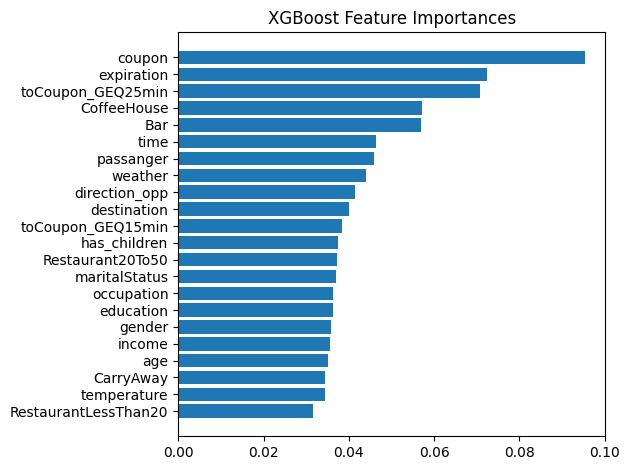

In [34]:
feature_names = x_train.columns.values
tree_feature_importances = rs_clf.best_estimator_.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("XGBoost Feature Importances")
fig.tight_layout()
plt.show()